In [1]:
import pandas as pd
import numpy as np
import pandas_datareader as pdr
import yfinance as yf
yf.pdr_override()
from scipy.stats import norm
import plotly.graph_objs as go

In [8]:
ticker = "DIS"

data = pdr.get_data_yahoo(ticker, start="2017-01-01")["Adj Close"]

In [9]:
data.tail()

Date
2020-10-01    123.309998
2020-10-02    122.550003
2020-10-05    123.370003
2020-10-06    120.930000
2020-10-07    123.080002
Name: Adj Close, dtype: float64

In [10]:
log_ret = np.log(data/data.shift(1))

In [13]:
mu = log_ret.mean()
var = log_ret.var()
# stdev = np.sqrt(var)
stdev = log_ret.std()

In [19]:
drift = mu  - (var/2)
drift

4.148961627205782e-05

In [20]:
t_intervals = 252
iterations = 10000

In [115]:
daily_returns = np.exp((stdev * norm.ppf(np.random.rand(t_intervals, iterations))))

In [116]:
S0 = data.iloc[-1]


daily_price = np.zeros_like(daily_returns)
daily_price[0] = S0
daily_price

array([[123.08000183, 123.08000183, 123.08000183, ..., 123.08000183,
        123.08000183, 123.08000183],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ]])

In [117]:
for t in range(1, t_intervals):
    daily_price[t] = daily_price[t-1] * daily_returns[t]

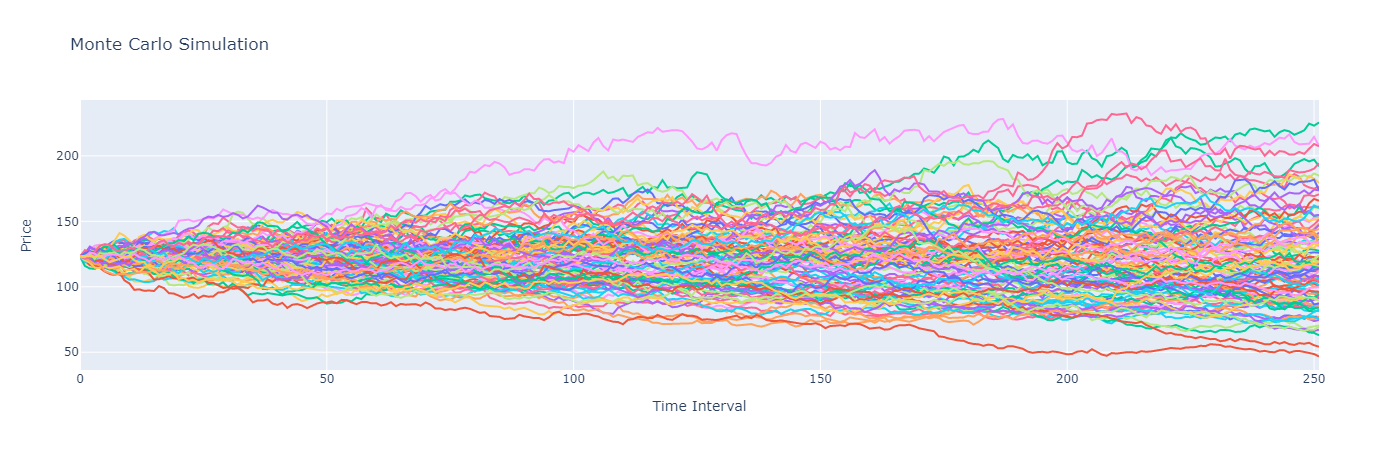

In [118]:
plots = []

for i in range(100,200):
    plot = go.Scatter(y = daily_price[:, i])
    plots.append(plot)


layout = go.Layout(title = f'Monte Carlo Simulation', yaxis = dict(title = 'Price'), 
                   xaxis = dict(title = 'Time Interval'), showlegend=False)    

fig = go.Figure(data=plots, layout=layout)
fig.show()

In [104]:
terminal_prices = pd.DataFrame({"Initial": daily_price[0], "Terminal": daily_price[-1]})
terminal_prices["Percent_Change"] = (terminal_prices["Terminal"]/terminal_prices["Initial"]) - 1
terminal_prices.sort_values(by=["Percent_Change"], inplace=True)
terminal_prices

,Initial,Terminal,Percent_Change
5592,123.080002,43.815574,-0.644007
9894,123.080002,44.609888,-0.637554
2737,123.080002,47.518018,-0.613926
1687,123.080002,48.050792,-0.609597
5520,123.080002,48.072854,-0.609418
...,...,...,...
1874,123.080002,305.631271,1.483192
2106,123.080002,308.717150,1.508264
8210,123.080002,334.812746,1.720286
2900,123.080002,335.030421,1.722054


In [105]:
conf = 0.95
var = terminal_prices.iloc[int(terminal_prices['Percent_Change'].count() * (1-conf))]['Percent_Change']
var

-0.3756047783552866

In [106]:
conf = 0.95
cvar = terminal_prices.iloc[:int(terminal_prices['Percent_Change'].count() * (1-conf))]['Percent_Change'].mean()
cvar

-0.4460610332625266

In [107]:
t = pd.DataFrame(daily_price)
t = t.pct_change()
y = t.rolling(10).sum().dropna()
y = y.apply(lambda x: x.sort_values().values)
VaRs = y.apply(lambda x: x.iloc[int(x.count() * (1-conf))])


In [108]:
VaRs.mean() *100

-8.868899603542408

In [109]:
r = log_ret.rolling(10).sum().dropna()
r = r.sort_values()
VaR = r.iloc[int(r.count() * (1-conf))]

In [110]:
VaR *100

-6.134310539287173

In [111]:
CVaRs = y.apply(lambda x: x.iloc[:int(x.count() * (1-conf))].mean())
CVaR = r.iloc[:int(r.count() * (1-conf))].mean()

In [112]:
CVaRs.mean() *100

-10.933086433686928

In [113]:
CVaR * 100

-12.840243794592677

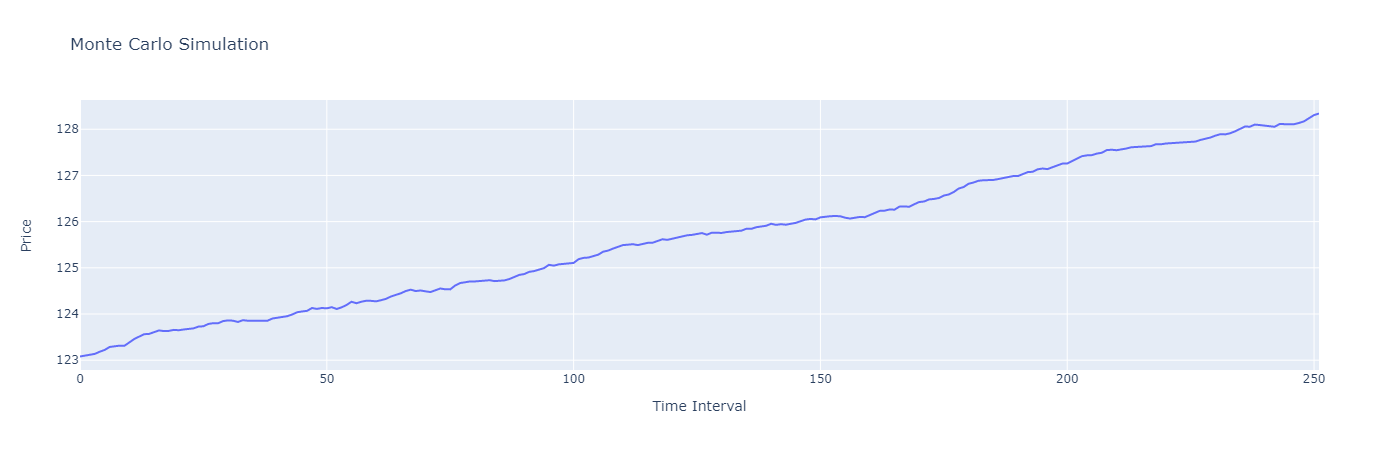

In [119]:
plot = go.Scatter(y = daily_price.mean(axis=1))

layout = go.Layout(title = f'Monte Carlo Simulation', yaxis = dict(title = 'Price'), 
                   xaxis = dict(title = 'Time Interval'), showlegend=False)    

fig = go.Figure(data=plot, layout=layout)
fig.show()